In [1]:
import csv
import time
import pandas as pd
from bs4 import BeautifulSoup
import requests
import lxml
import re

In [155]:
url = "https://www.booking.com/searchresults.en-us.html?aid=898409&label=gen173nr-1FCAEoggI46AdIM1gEaKcCiAEBmAExuAEHyAEP2AEB6AEB-AECiAIBqAIDuALSw6XtBcACAQ&sid=7435f49ed9ca5ec29417bb500ad8762a&tmpl=searchresults&ac_click_type=b&ac_position=0&checkin_month=11&checkin_monthday=2&checkin_year=2019&checkout_month=11&checkout_monthday=3&checkout_year=2019&city=-2140479&class_interval=1&dest_id=-2601889&dest_type=city&dtdisc=0&from_sf=1&group_adults=2&group_children=0&iata=LON&inac=0&index_postcard=0&label_click=undef&no_rooms=1&postcard=0&raw_dest_type=city&room1=A%2CA&sb_price_type=total&search_selected=1&shw_aparth=1&slp_r_match=0&src=searchresults&src_elem=sb&srpvid=d71a0373890001c4&ss=London%2C%20Greater%20London%2C%20United%20Kingdom&ss_all=0&ss_raw=london&ssb=empty&sshis=0&ssne=Amsterdam&ssne_untouched=Amsterdam&top_ufis=1&rows=25&offset={}"

headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:69.0) Gecko/20100101 Firefox/69.0'}


# open the file to save the review
csvFile = open('hotel_paris.csv', 'w')
csvWriter = csv.writer(csvFile, delimiter=',')

for i in range(0, 2000, 25):
    
    
    web = requests.get(url.format(i), headers=headers)
    time.sleep(5)
    bs = BeautifulSoup(web.text, 'lxml')
    
    hotels = bs.select("#hotellist_inner div.sr_item.sr_item_new")
    
    for j in hotels:
    
        name = j.find('span', {'class': 'sr-hotel__name'}).text.strip()
        #print(name)
        
        if j.find('div', {'class': 'roomPrice'}) is not None:
            price = j.find('div', {'class': 'roomPrice'}).find('span', {'class': "bui-u-sr-only"}).text.split('Price')[-1].split('US$')[-1].strip()
        else:
            price = 'NA'
        
        location = j.find('a', {'class', 'bui-link'}).text.split(',')[0].strip()
        
        distance = j.find('div', {'class', 'sr_card_address_line'}).text.split('Show on map')[1].split('from centre')[0].strip()    
        
        #score = j.find('div', {'class', 'sr-review-score_badge'}).text
        if j.find('div', {'class': 'bui-review-score'}) is not None:
            result = j.find('div', {'class': 'bui-review-score'}).text
            #score = re.findall(r'\d+', result) only return whole number
            score = j.find('div', {'class': 'bui-review-score'}).text.split(sep='    ', maxsplit=2)[0].strip()
            rate = j.find('div', {'class': 'bui-review-score'}).text.split(sep='    ', maxsplit=4)[1].split('   ')[0].strip()
            
        else:
            score = 'NA'
        
        if j.find('span', {'class', 'review-score-badge'}) is not None:
            location_score = j.find('span', {'class', 'review-score-badge'}).text.strip()
        else:
            location_score = 'NA'
        
        if j.find('div', {'class': 'sr-review-score'}) is not None:
            # we are trying to extract the review numbers of hotel. Notice it is the 2nd one from the text printout
            reviews = j.find('div', {'class': 'sr-review-score'}).text.replace(',', '').replace('.', '')
            num_reviews = re.findall(r'\d+', reviews)[1]
        else:
            num_reviews = 'NA'
            
    
#df = pd.DataFrame(data, columns = ['name', 'price', 'location', 'distance', 'score', 'rate', 'location_score', 'num_reviews'])
    
#df.to_csv('hotel_paris.csv', sep=',', float_format='%.1f')

        csvWriter.writerow([name, price, location, distance, score, rate, location_score, num_reviews])
        
csvFile.close()


In [2]:
paris = pd.read_csv('hotel_paris.csv', header = None,
                    names = ['name', 'price', 'location', 'distance', 'score', 'rating', 'location_score', 'num_reviews'])
paris.drop('location_score', axis = 1, inplace = True)
paris.dropna(inplace = True)
paris.head()

,name,price,location,distance,score,rating,num_reviews
0,Hôtel Juliana Paris,408,7th arr.,2.2 miles,8.6,Fabulous,542.0
1,ibis budget Paris Porte De Montmartre,59,18th arr.,3.1 miles,6.4,Review score,12693.0
3,Hotel Pierre Nicole,117,5th arr.,1.3 miles,8.5,Very good,226.0
4,Nouvel hotel,106,12th arr.,2.2 miles,8.3,Very good,266.0
5,Beausejour Ranelagh,118,16th arr.,3.7 miles,7.9,Good,576.0


In [3]:
def clean_dist(x):
    distance = []
    for dist in x.values:
        if re.findall('feet', dist):
            dist = re.sub('feet', '', dist)
            dist = re.sub(',', '', dist)
            dist = round(float(dist)*0.00019, 1)
        distance.append(dist)
    return distance
paris['distance'] = clean_dist(paris['distance'])

In [4]:
paris['distance'] = paris['distance'].astype(str).str.rstrip('miles')

paris.head()

,name,price,location,distance,score,rating,num_reviews
0,Hôtel Juliana Paris,408,7th arr.,2.2,8.6,Fabulous,542.0
1,ibis budget Paris Porte De Montmartre,59,18th arr.,3.1,6.4,Review score,12693.0
3,Hotel Pierre Nicole,117,5th arr.,1.3,8.5,Very good,226.0
4,Nouvel hotel,106,12th arr.,2.2,8.3,Very good,266.0
5,Beausejour Ranelagh,118,16th arr.,3.7,7.9,Good,576.0


# Remove any unwated data from column location

In [5]:
#paris = paris.query("location != 'Paris\n\n\nShow on map'", inplace = True)
#paris['location' != 'Paris\n\n\nShow on map']
paris = paris[paris['location'] != 'Paris\n\n\nShow on map']

In [6]:
set(paris['location'])

{'10th arr.',
 '11th arr.',
 '12th arr.',
 '13th arr.',
 '14th arr.',
 '15th arr.',
 '16th arr.',
 '17th arr.',
 '18th arr.',
 '19th arr.',
 '1st arr.',
 '20th arr.',
 '2nd arr.',
 '3rd arr.',
 '4th arr.',
 '5th arr.',
 '6th arr.',
 '7th arr.',
 '8th arr.',
 '9th arr.'}

Because data from booking use "," for thousand number, we have to re-format data in column "price" so that python can understand

In [7]:
paris['price'] = paris['price'].str.replace(',', '')
paris['price'] = paris['price'].astype(float)

paris['distance'] = paris['distance'].astype(float)
paris['score'] = paris['score'].astype(float)
paris.drop_duplicates(subset = None, keep = "first", inplace = True)

# Create a graph to observe the distribution of Hotel price in Paris

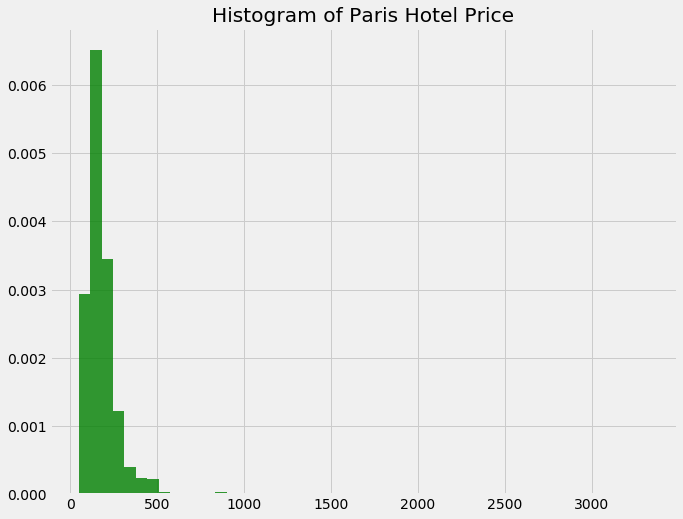

In [9]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.figure(figsize = (10, 8))
n, bins, patches = plt.hist(paris['price'], bins = 50, facecolor = "green", density = True, alpha = 0.8)

plt.title('Histogram of Paris Hotel Price')

plt.show()

/Users/Mavis/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


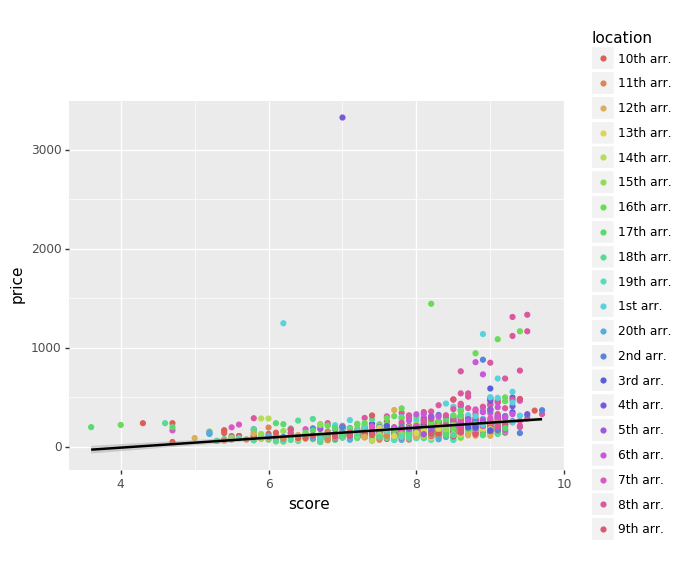

<ggplot: (305373897)>

In [10]:
import plotnine as p9

p9.ggplot(paris, p9.aes(x = 'score', y = 'price')) + p9.geom_point(p9.aes(color = 'location')) \
+ p9.geom_smooth(method = "lm")

We notice that our data has outliers and the distribution is skewed to the right. We need to remove outliers before applying any statistical modeling.

/Users/Mavis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


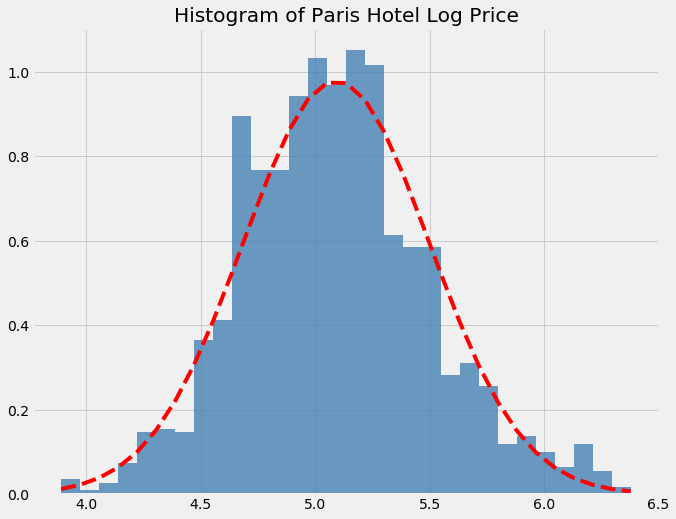

In [11]:
paris = paris[(paris.price <= 600)]
import numpy as np
paris['logprice'] = np.log(paris.price)

plt.figure(figsize = (10, 8))
n, bins, patches = plt.hist(paris['logprice'], bins = 30, facecolor = "steelblue", density = True, alpha = 0.8)

# add a 'best fit' line
mu = np.mean(paris['logprice'])
sigma = np.std(paris['logprice'])
import scipy.stats 
_ = scipy.stats.norm.pdf(bins, mu, sigma)
plt.plot(bins, _, 'r--')

plt.title('Histogram of Paris Hotel Log Price')

plt.show()

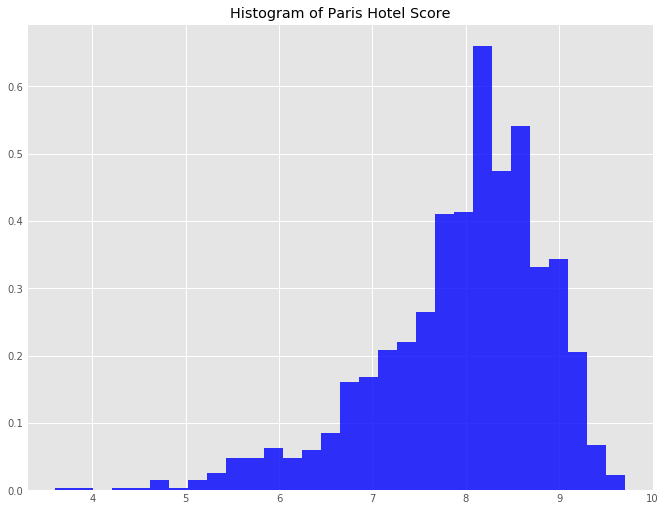

In [12]:
from matplotlib import style
style.use('ggplot')
plt.figure(figsize = (10, 8))
n, bins, patches = plt.hist(paris['score'], bins = 30, facecolor = "blue", density = True, alpha = 0.8)
plt.title('Histogram of Paris Hotel Score')
plt.show()

/Users/Mavis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


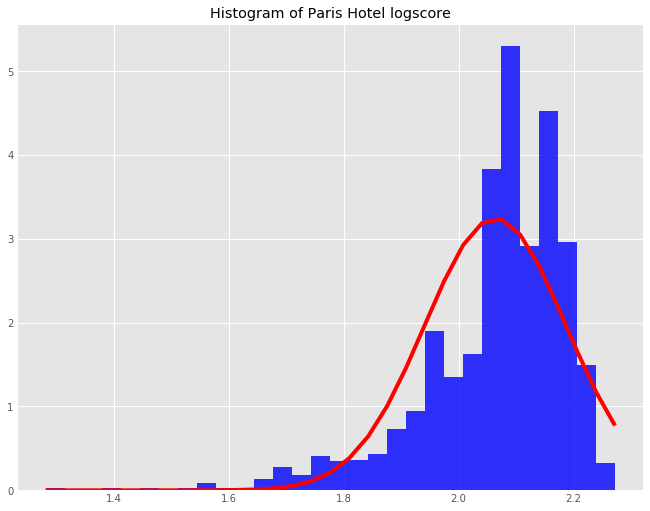

In [14]:
#paris['inverse'] = 1/paris.score
#paris = paris[(paris.score >= 5.0)]
paris['logscore'] = np.log(paris.score)

plt.figure(figsize = (10, 8))
n, bins, patches = plt.hist(paris.logscore, bins = 30, facecolor = "blue", density = True, alpha = 0.8)

mu = np.mean(paris['logscore'])
sigma = np.std(paris['logscore'])
import scipy.stats 
_ = scipy.stats.norm.pdf(bins, mu, sigma)
plt.plot(bins, _, 'r-')

plt.title('Histogram of Paris Hotel logscore')
plt.show()

# Look at the boxplot graph of num_reviews

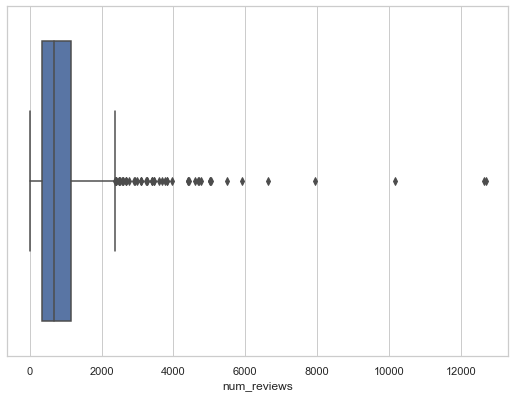

In [14]:
import seaborn as sns
plt.figure(figsize = (8, 6))
sns.set(style = "whitegrid")
ax = sns.boxplot(x = paris.num_reviews, orient = 'h')

In [15]:
paris.iloc[[paris['num_reviews'].idxmax(),]]

,name,price,location,distance,score,rating,num_reviews,logprice,cube_score
1,ibis budget Paris Porte De Montmartre,59.0,18th arr.,3.1,6.4,Review score,12693.0,4.077537,262.144


In [16]:
paris[(paris.num_reviews >= 12000)]

,name,price,location,distance,score,rating,num_reviews,logprice,cube_score
1,ibis budget Paris Porte De Montmartre,59.0,18th arr.,3.1,6.4,Review score,12693.0,4.077537,262.144
26,citizenM Paris Gare de Lyon,149.0,12th arr.,1.3,8.8,Fabulous,12645.0,5.003946,681.472


# We will now try to sort our data by location column

In [15]:
paris['location'] = paris['location'].str.strip('arr.')
paris['sort'] = paris['location'].str.extract('(\d+)', expand=False).astype(int)
paris.sort_values('sort',inplace = True)
paris.drop('sort',axis=1, inplace = True)
paris.head()

/Users/Mavis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/Mavis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Mavis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: htt

,name,price,location,distance,score,rating,num_reviews,logprice,logscore
586,Hôtel Crayon by Elegancia,177.0,1st,0.7,8.1,Very good,335.0,5.176150,2.091864
436,Hotel Louvre Bons Enfants,188.0,1st,0.7,7.8,Good,1014.0,5.236442,2.054124
376,Handsome Hotel By Elegancia,188.0,1st,0.4,8.4,Very good,369.0,5.236442,2.128232
1657,Sweet Inn -Etienne Marcel,437.0,1st,0.6,8.4,Very good,44.0,6.079933,2.128232
375,Hôtel Mansart - Esprit de France,235.0,1st,1.3,8.7,Fabulous,551.0,5.459586,2.163323


In [16]:
paris.reset_index(inplace = True)
paris.head()

,index,name,price,location,distance,score,rating,num_reviews,logprice,logscore
0,586,Hôtel Crayon by Elegancia,177.0,1st,0.7,8.1,Very good,335.0,5.176150,2.091864
1,436,Hotel Louvre Bons Enfants,188.0,1st,0.7,7.8,Good,1014.0,5.236442,2.054124
2,376,Handsome Hotel By Elegancia,188.0,1st,0.4,8.4,Very good,369.0,5.236442,2.128232
3,1657,Sweet Inn -Etienne Marcel,437.0,1st,0.6,8.4,Very good,44.0,6.079933,2.128232
4,375,Hôtel Mansart - Esprit de France,235.0,1st,1.3,8.7,Fabulous,551.0,5.459586,2.163323


In [17]:
paris.drop('index', axis = 1, inplace=True)
paris.head()

,name,price,location,distance,score,rating,num_reviews,logprice,logscore
0,Hôtel Crayon by Elegancia,177.0,1st,0.7,8.1,Very good,335.0,5.176150,2.091864
1,Hotel Louvre Bons Enfants,188.0,1st,0.7,7.8,Good,1014.0,5.236442,2.054124
2,Handsome Hotel By Elegancia,188.0,1st,0.4,8.4,Very good,369.0,5.236442,2.128232
3,Sweet Inn -Etienne Marcel,437.0,1st,0.6,8.4,Very good,44.0,6.079933,2.128232
4,Hôtel Mansart - Esprit de France,235.0,1st,1.3,8.7,Fabulous,551.0,5.459586,2.163323


Text(0.5, 1.0, 'Boxplot Graph on Paris Hotel Location')

<Figure size 720x576 with 0 Axes>

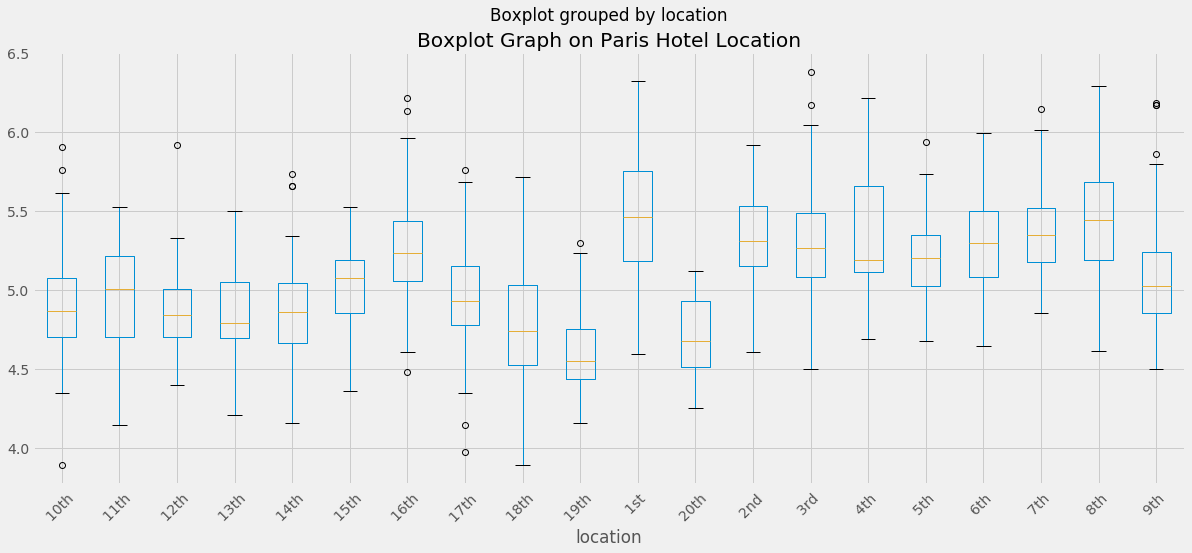

In [18]:
#plt.boxplot(paris.location, paris.logprice)
plt.style.use('fivethirtyeight')
plt.figure(figsize = (10, 8))
paris.boxplot(column = 'logprice', by = 'location', figsize = (20, 8), rot = 45)

plt.title('Boxplot Graph on Paris Hotel Location')

Text(0.5, 0.98, 'Boxplot of Paris Hotel Score and LogPrice by Location')

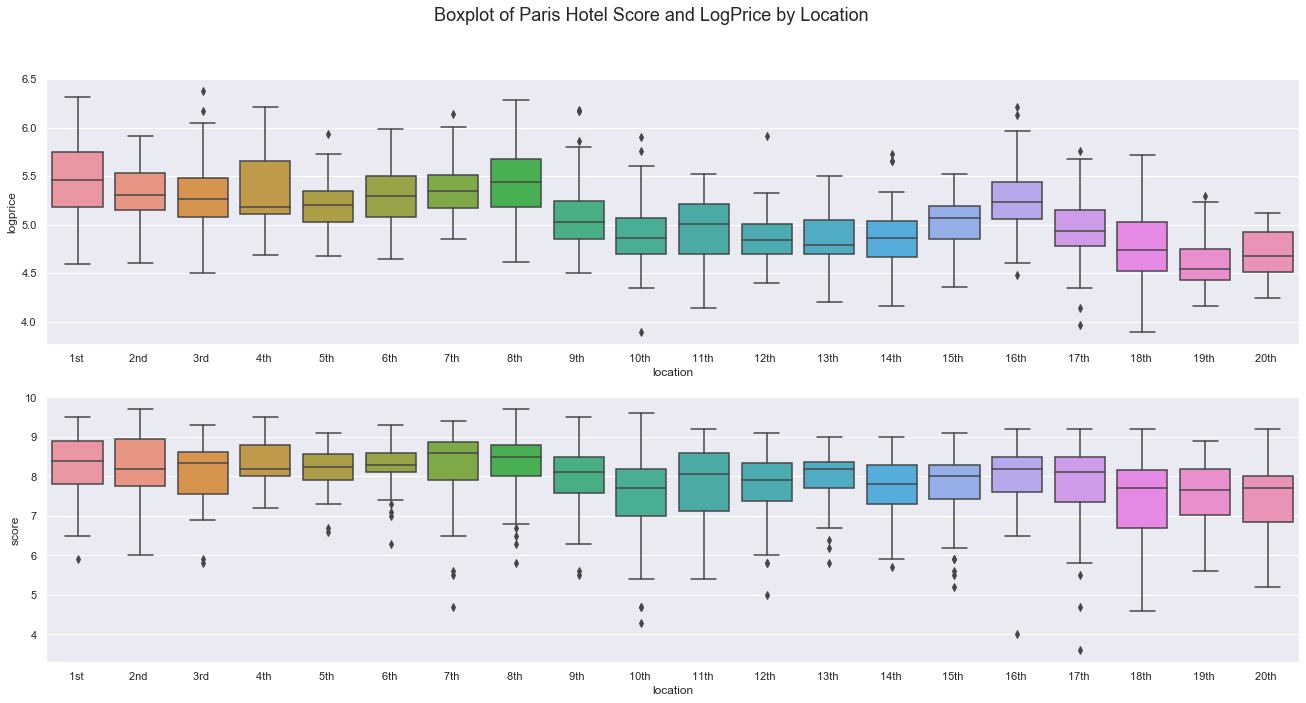

In [19]:
import seaborn as sns
sns.set(style = 'darkgrid')
fig, axes = plt.subplots(2, 1)
fig = plt.gcf()
fig.set_size_inches(20, 10)
sns.boxplot(y = "logprice", x = "location", data = paris, ax=axes[0])
sns.boxplot(y = "score", x = "location", data = paris, ax=axes[1])
plt.suptitle('Boxplot of Paris Hotel Score and LogPrice by Location', size = 18)

In [20]:
print('Number of hotel prices that are available in each district', paris.location.value_counts())

Number of hotel prices that are available in each district 9th      136
8th      121
17th     104
10th     100
16th      88
15th      82
18th      75
6th       71
11th      68
14th      67
1st       62
5th       58
12th      56
7th       42
2nd       39
13th      38
3rd       36
4th       27
19th      26
20th      23
Name: location, dtype: int64


In [21]:
paris.groupby('location')['score'].apply(lambda x: x.mean()).sort_values(ascending=False)

location
8th      8.360331
4th      8.344444
6th      8.314085
1st      8.245161
5th      8.215517
7th      8.166667
2nd      8.161538
3rd      8.083333
9th      7.995588
16th     7.981818
13th     7.942105
17th     7.837500
11th     7.817647
15th     7.778049
12th     7.748214
14th     7.705970
19th     7.557692
18th     7.464000
10th     7.442000
20th     7.304348
Name: score, dtype: float64

In [22]:
paris.groupby('location')['price'].mean().sort_values(ascending=False)

location
1st      259.467742
8th      250.702479
4th      233.370370
7th      226.880952
3rd      217.000000
2nd      215.743590
6th      208.802817
16th     201.909091
5th      186.637931
9th      169.102941
15th     155.878049
11th     149.647059
17th     148.961538
10th     140.830000
14th     136.268657
12th     134.339286
13th     129.500000
18th     128.600000
20th     114.130435
19th     105.615385
Name: price, dtype: float64

In [24]:
from statsmodels.formula.api import ols
result = ols(formula="logprice ~ score", data=paris)
result = result.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logprice   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     479.7
Date:                Fri, 20 Mar 2020   Prob (F-statistic):           6.37e-91
Time:                        15:55:42   Log-Likelihood:                -482.62
No. Observations:                1319   AIC:                             969.2
Df Residuals:                    1317   BIC:                             979.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2234      0.086     37.536      0.000       3.055       3.392
score          0.2356      0.011     21.902      0.000       0.215       0.257
==============================================================================
Omnibus:                       66.340   Durbin-Watson:                   1.477
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.382
Skew:                           0.534   Prob(JB):                     1.57e-17
Kurtosis:                       3.517   Cond. No.                         72.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'Paris Hotel Score and Price ')

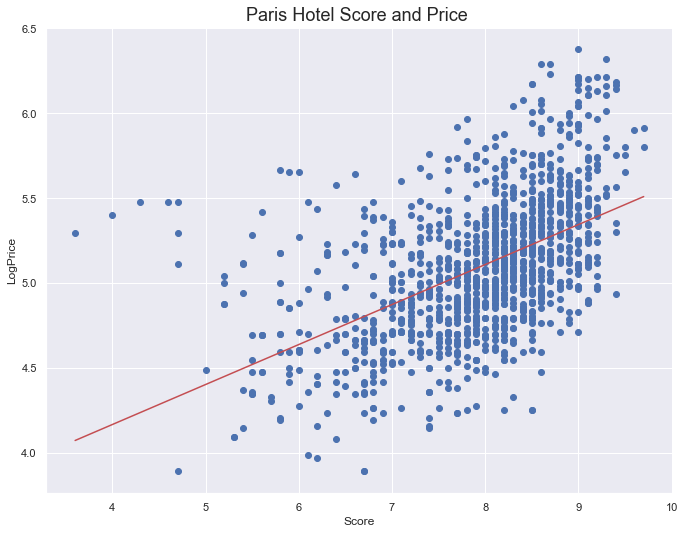

In [25]:
import statsmodels.api as sm

import numpy as np

plt.figure(figsize = (10, 8))

plt.scatter(paris['score'], paris['logprice'], color = 'b')

x_pred = np.linspace(paris['score'].min(), paris['score'].max(), 50)
#x_pred2 = sm.add_constant(x_pred)

df_predict = pd.DataFrame(x_pred, columns=['score'])
y_pred = result.predict(df_predict)
plt.plot(x_pred, y_pred, color = 'r')

plt.grid(True)

plt.xlabel('Score')
plt.ylabel('LogPrice')

plt.title('Paris Hotel Score and Price ', size = 18)

In [30]:
colname = ['num_reviews']
for i in colname:
    Q3, Q1 = np.percentile(paris.loc[:,i], [75, 25])
    IQR = Q3 - Q1

min = Q1 - (IQR*1.5)
max = Q3 + (IQR*1.5)

paris_num = paris.copy()

paris_num = paris_num.drop(paris_num[paris_num.loc[:, i] < min].index)
paris_num = paris_num.drop(paris_num[paris_num.loc[:, i] > max].index)

print(min)
print(max)

-880.0
2372.0


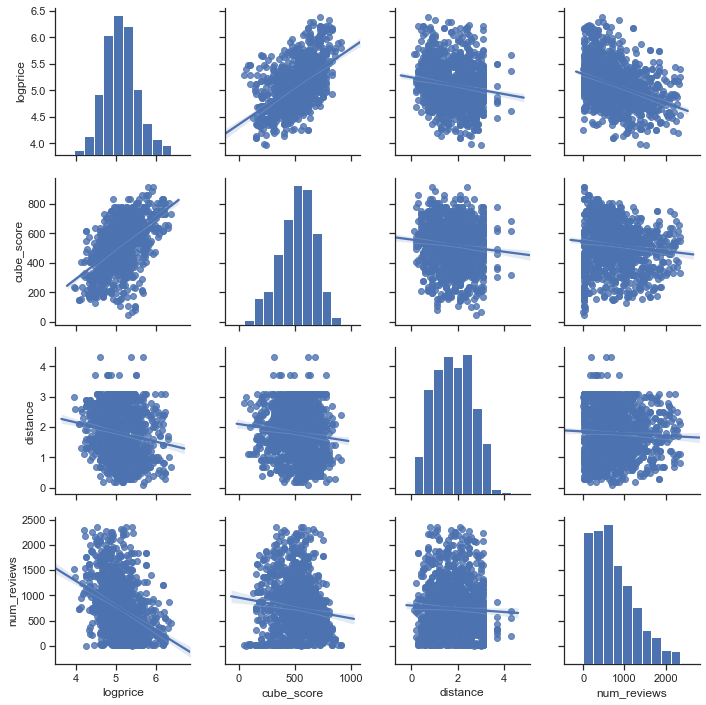

In [31]:
paris_numerical = paris_num[['logprice', 'cube_score', 'distance', 'num_reviews']]

sns.set(style = "ticks", color_codes = True)
sns.pairplot(data = paris_numerical, kind = 'reg', dropna = True)
plt.show()

In [32]:
paris_numerical.corr(method = \
                     'pearson').style.format('{:.2f}').background_gradient(cmap \
                                                                           = plt.get_cmap('coolwarm'), axis = 1)

,logprice,cube_score,distance,num_reviews
logprice,1.00,0.55,-0.16,-0.37
cube_score,0.55,1.00,-0.11,-0.12
distance,-0.16,-0.11,1.00,-0.05
num_reviews,-0.37,-0.12,-0.05,1.00


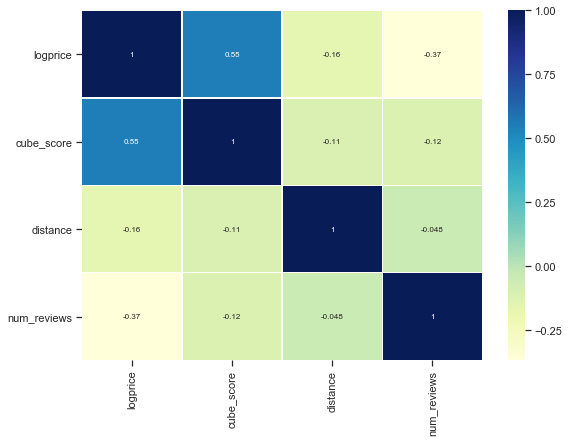

In [33]:
plt.figure(figsize = (8, 6))
sns.heatmap(paris_numerical.corr(),
            annot=True,
            cmap="YlGnBu", 
            linewidths=0.3,
            annot_kws={"size": 8})

# Plot aesthetics
plt.xticks(rotation=90)
plt.yticks(rotation=0) 
plt.show()

# It is also helpful to look at the distribution of logprice on different ratings from customers

In [34]:
set(paris.rating)

{'Exceptional', 'Fabulous', 'Good', 'Review score', 'Superb', 'Very good'}

Text(0.5, 0.98, 'Distribution of Paris Hotel LogPrice on Different Rating')

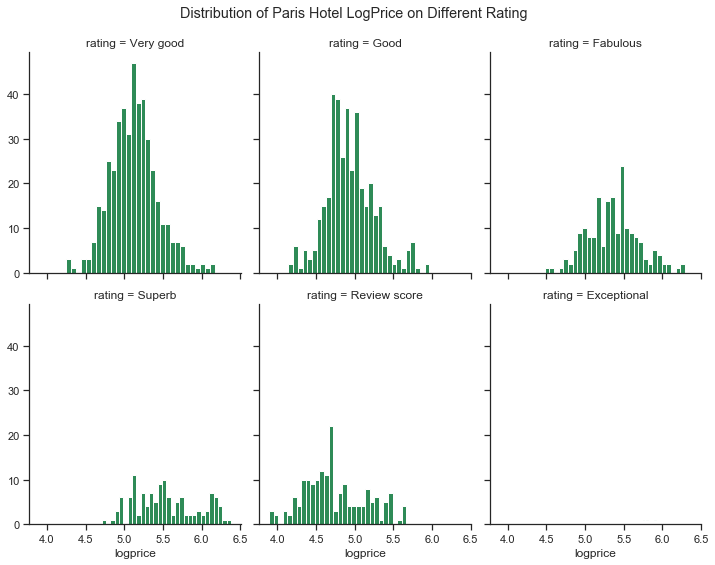

In [35]:
import seaborn as sns
sns.set(style="ticks", color_codes = True)
grid = sns.FacetGrid(paris, col = 'rating', col_wrap = 3)
grid.fig.set_size_inches(10, 8)
grid.map(plt.hist, 'logprice', edgecolor="w", color = "seagreen", bins=30)
plt.subplots_adjust(top = 0.9)
grid.fig.suptitle('Distribution of Paris Hotel LogPrice on Different Rating')
# sns.plt.title('YOUR TITLE HERE')

# We will calculate the root mean square error and the R2 of our model

In [26]:
prediction = result.predict(paris['score'])

pred_df = pd.DataFrame({'logprice': paris.logprice, 'price': paris.price, 'logpred': prediction})
pred_df['pred'] = np.exp(pred_df['logpred'])
pred_df['residuals'] = pred_df['pred'] - pred_df['price']
pred_df['residuals2'] = pred_df['logpred'] - pred_df['logprice']
pred_df.head()

,logprice,price,logpred,pred,residuals,residuals2
0,5.176150,177.0,5.132002,169.355844,-7.644156,-0.044148
1,5.236442,188.0,5.061312,157.797376,-30.202624,-0.175130
2,5.236442,188.0,5.202692,181.760955,-6.239045,-0.033750
3,6.079933,437.0,5.202692,181.760955,-255.239045,-0.877241
4,5.459586,235.0,5.273383,195.074726,-39.925274,-0.186203


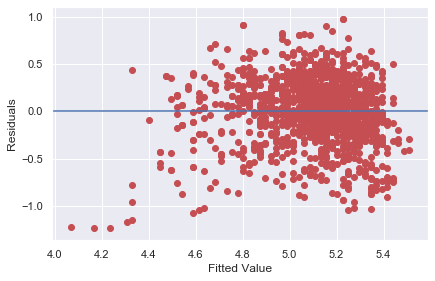

In [27]:
plt.scatter(pred_df.logpred, pred_df.residuals2, color = 'r')
plt.axhline(0, color = 'b')
plt.xlabel('Fitted Value')
plt.ylabel('Residuals')
plt.show()

(array([  4.,   1.,   6.,   2.,   9.,  11.,  17.,  24.,  24.,  21.,  34.,
         41.,  53.,  71.,  82.,  96., 132., 119., 126., 125.,  86.,  92.,
         57.,  32.,  18.,  20.,   2.,   8.,   1.,   5.]),
 array([-1.23987198, -1.1659509 , -1.09202981, -1.01810873, -0.94418764,
        -0.87026656, -0.79634547, -0.72242438, -0.6485033 , -0.57458221,
        -0.50066113, -0.42674004, -0.35281896, -0.27889787, -0.20497679,
        -0.1310557 , -0.05713461,  0.01678647,  0.09070756,  0.16462864,
         0.23854973,  0.31247081,  0.3863919 ,  0.46031298,  0.53423407,
         0.60815515,  0.68207624,  0.75599733,  0.82991841,  0.9038395 ,
         0.97776058]),
 <a list of 30 Patch objects>)

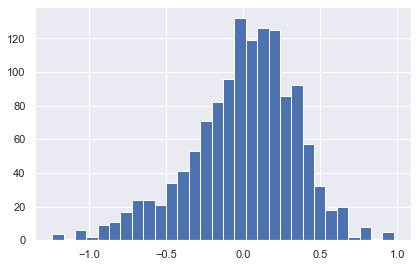

In [28]:
plt.hist(pred_df.residuals2, bins=30)

In [29]:
RMSE = np.sqrt(np.mean(pred_df['residuals']**2))
print(f'The Linear Regression of Price on Score has RMSE: {RMSE:.4f}')

The Linear Regression of Price on Score has RMSE: 70.3990


In [40]:
R2 = 1 - np.var(pred_df['residuals'])/np.var(pred_df['price'])
print(f'The Linear Regression of Price on Score has R2: {R2:.4f}')

The Linear Regression of Price on Score has R2: 0.2841


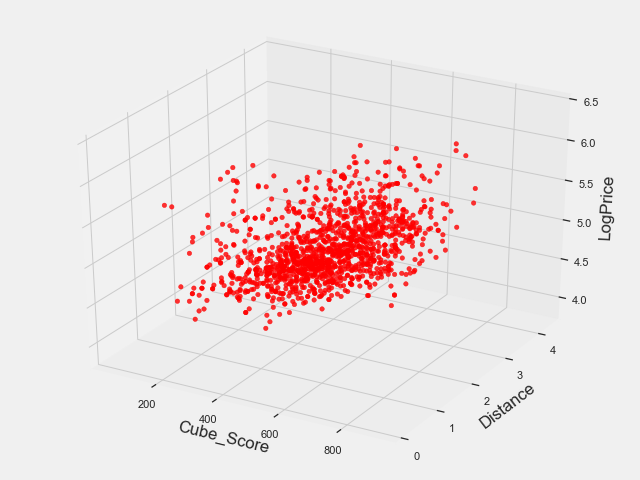

In [41]:
%matplotlib inline 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import style

style.use('fivethirtyeight')

graph_3d = plt.figure(figsize = (10, 8)).gca(projection='3d')
graph_3d.scatter(paris.cube_score, paris.distance, paris.logprice, color = "red", alpha = 0.8)
#graph_3d.plot(paris.score, paris.distance, paris.logprice, color = "red")
graph_3d.set_xlabel('Cube_Score')
graph_3d.set_ylabel('Distance')
graph_3d.set_zlabel('LogPrice')
plt.show()

In [30]:
paris_m1 = ols(formula="logprice ~ score + distance", data=paris)
paris_m1 = paris_m1.fit()
paris_m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logprice   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     258.1
Date:                Fri, 20 Mar 2020   Prob (F-statistic):           2.75e-95
Time:                        15:57:19   Log-Likelihood:                -469.22
No. Observations:                1319   AIC:                             944.4
Df Residuals:                    1316   BIC:                             960.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3851      0.091     37.381      0.000       3.207       3.563
score          0.2293      0.011     21.384      0.000       0.208       0.250
distance      -0.0615      0.012     -5.197      0.000      -0.085      -0.038
==============================================================================
Omnibus:                       84.846   Durbin-Watson:                   1.499
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.029
Skew:                           0.623   Prob(JB):                     6.99e-23
Kurtosis:                       3.553   Cond. No.                         79.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
paris_m2 = ols(formula="logprice ~ score + location", data=paris)
paris_m2 = paris_m2.fit()
paris_m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logprice   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     57.88
Date:                Fri, 20 Mar 2020   Prob (F-statistic):          1.43e-163
Time:                        15:57:25   Log-Likelihood:                -267.00
No. Observations:                1319   AIC:                             576.0
Df Residuals:                    1298   BIC:                             684.9
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.5867      0.079     45.687      0.000       3.433       3.741
location[T.11th ]    -0.0208      0.047     -0.443      0.658      -0.113       0.072
location[T.12th ]    -0.0854      0.050     -1.710      0.088      -0.183       0.013
location[T.13th ]    -0.1610      0.057     -2.818      0.005      -0.273      -0.049
location[T.14th ]    -0.0735      0.047     -1.556      0.120      -0.166       0.019
location[T.15th ]     0.0633      0.045      1.419      0.156      -0.024       0.151
location[T.16th ]     0.2680      0.044      6.095      0.000       0.182       0.354
location[T.17th ]    -0.0107      0.042     -0.256      0.798      -0.093       0.072
location[T.18th ]    -0.1353      0.046     -2.967      0.003      -0.225      -0.046
location[T.19th ]    -0.3079      0.066     -4.683      0.000      -0.437      -0.179
location[T.1st ]      0.4431      0.049      9.060      0.000       0.347       0.539
location[T.20th ]    -0.1676      0.069     -2.427      0.015      -0.303      -0.032
location[T.2nd ]      0.2962      0.057      5.213      0.000       0.185       0.408
location[T.3rd ]      0.2807      0.058      4.807      0.000       0.166       0.395
location[T.4th ]      0.3063      0.065      4.686      0.000       0.178       0.435
location[T.5th ]      0.1634      0.050      3.276      0.001       0.066       0.261
location[T.6th ]      0.2484      0.047      5.271      0.000       0.156       0.341
location[T.7th ]      0.3596      0.055      6.495      0.000       0.251       0.468
location[T.8th ]      0.3929      0.041      9.503      0.000       0.312       0.474
location[T.9th ]      0.0806      0.040      2.029      0.043       0.003       0.158
score                 0.1758      0.010     18.021      0.000       0.157       0.195
==============================================================================
Omnibus:                      119.407   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              170.460
Skew:                           0.700   Prob(JB):                     9.66e-38
Kurtosis:                       4.069   Cond. No.                         137.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# By using categorical variable location instead distance, our model increases R2 significantly better than the last one.

In [32]:
prediction2 = paris_m2.predict(paris[['score', 'location']])

pred_df2 = pd.DataFrame({'logprice': paris.logprice, 'price': paris.price, 'logpred': prediction2})
pred_df2['pred'] = np.exp(pred_df2['logpred'])
pred_df2['residuals'] = pred_df2['pred'] - pred_df2['price']
pred_df2['residuals2'] = pred_df2['logpred'] - pred_df2['logprice']
pred_df2.head()

,logprice,price,logpred,pred,residuals,residuals2
0,5.176150,177.0,5.453940,233.677020,56.677020,0.277790
1,5.236442,188.0,5.401195,221.671177,33.671177,0.164753
2,5.236442,188.0,5.506685,246.333106,58.333106,0.270243
3,6.079933,437.0,5.506685,246.333106,-190.666894,-0.573248
4,5.459586,235.0,5.559430,259.674654,24.674654,0.099844


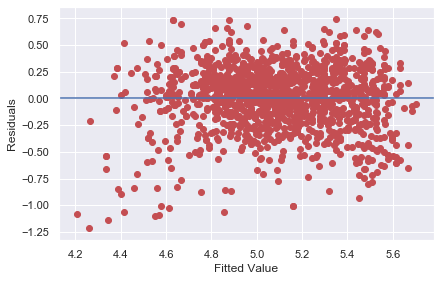

In [33]:
plt.scatter(pred_df2.logpred, pred_df2.residuals2, color = 'r')
plt.axhline(0, color = 'b')
plt.xlabel('Fitted Value')
plt.ylabel('Residuals')
plt.show()

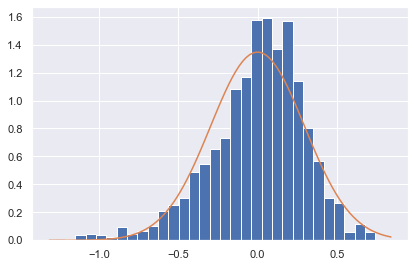

In [36]:
plt.hist(pred_df2.residuals2, bins = 30, density=True)
from scipy.stats import norm
mean,std=norm.fit(pred_df2.residuals2)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std)
plt.plot(x, y)
plt.show()

In [47]:
pred_df2['cube_score'] = paris.cube_score
pred_df2['location'] = paris.location
pred_df2['resid2'] = paris_m2.resid**2
resid_test = ols(formula="resid2 ~ cube_score + location", data=pred_df2).fit()
resid_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 resid2   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     3.364
Date:                Sun, 08 Mar 2020   Prob (F-statistic):           7.92e-07
Time:                        01:16:24   Log-Likelihood:                 728.71
No. Observations:                1319   AIC:                            -1415.
Df Residuals:                    1298   BIC:                            -1307.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1234      0.018      6.762      0.000       0.088       0.159
location[T.11th ]     0.0203      0.022      0.916      0.360      -0.023       0.064
location[T.12th ]     0.0021      0.023      0.088      0.930      -0.044       0.048
location[T.13th ]    -0.0127      0.027     -0.474      0.635      -0.065       0.040
location[T.14th ]     0.0233      0.022      1.049      0.295      -0.020       0.067
location[T.15th ]    -0.0054      0.021     -0.257      0.797      -0.047       0.036
location[T.16th ]     0.0326      0.021      1.579      0.115      -0.008       0.073
location[T.17th ]     0.0339      0.020      1.718      0.086      -0.005       0.073
location[T.18th ]     0.0720      0.021      3.357      0.001       0.030       0.114
location[T.19th ]     0.0575      0.031      1.862      0.063      -0.003       0.118
location[T.1st ]      0.0335      0.023      1.457      0.145      -0.012       0.079
location[T.20th ]     0.0280      0.032      0.861      0.389      -0.036       0.092
location[T.2nd ]      0.0116      0.027      0.433      0.665      -0.041       0.064
location[T.3rd ]      0.0506      0.027      1.844      0.065      -0.003       0.104
location[T.4th ]      0.0382      0.031      1.244      0.214      -0.022       0.099
location[T.5th ]     -0.0104      0.023     -0.445      0.657      -0.056       0.036
location[T.6th ]      0.0072      0.022      0.327      0.744      -0.036       0.051
location[T.7th ]      0.0068      0.026      0.260      0.795      -0.044       0.058
location[T.8th ]      0.0746      0.019      3.838      0.000       0.036       0.113
location[T.9th ]      0.0065      0.019      0.350      0.727      -0.030       0.043
cube_score           -0.0001   2.67e-05     -4.616      0.000      -0.000   -7.09e-05
==============================================================================
Omnibus:                     1074.640   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23724.612
Skew:                           3.734   Prob(JB):                         0.00
Kurtosis:                      22.388   Cond. No.                     9.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [48]:
0.022 * 1227

26.994

In [49]:
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(paris_m2.resid, paris_m2.model.exog)
bp_test

(65.00629041407048,
 1.16438253903243e-06,
 3.3643775208938322,
 7.920241538447534e-07)

In [50]:
paris_m3 = ols(formula="logprice ~ rating + location", data=paris)
paris_m3 = paris_m3.fit()
paris_m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logprice   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     56.93
Date:                Sun, 08 Mar 2020   Prob (F-statistic):          4.72e-183
Time:                        01:16:46   Log-Likelihood:                -212.14
No. Observations:                1319   AIC:                             474.3
Df Residuals:                    1294   BIC:                             603.9
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5.5613      0.121     46.113      0.000       5.325       5.798
rating[T.Fabulous]        -0.3826      0.120     -3.194      0.001      -0.618      -0.148
rating[T.Good]            -0.7087      0.119     -5.960      0.000      -0.942      -0.475
rating[T.Review score]    -0.8406      0.120     -6.995      0.000      -1.076      -0.605
rating[T.Superb]          -0.2304      0.120     -1.913      0.056      -0.467       0.006
rating[T.Very good]       -0.5650      0.119     -4.758      0.000      -0.798      -0.332
location[T.11th ]         -0.0259      0.045     -0.570      0.569      -0.115       0.063
location[T.12th ]         -0.0736      0.048     -1.533      0.125      -0.168       0.021
location[T.13th ]         -0.1316      0.055     -2.393      0.017      -0.239      -0.024
location[T.14th ]         -0.0504      0.045     -1.109      0.267      -0.139       0.039
location[T.15th ]          0.0863      0.043      2.010      0.045       0.002       0.171
location[T.16th ]          0.2830      0.042      6.680      0.000       0.200       0.366
location[T.17th ]         -0.0079      0.040     -0.195      0.845      -0.087       0.071
location[T.18th ]         -0.1303      0.044     -2.966      0.003      -0.217      -0.044
location[T.19th ]         -0.2783      0.063     -4.404      0.000      -0.402      -0.154
location[T.1st ]           0.4287      0.047      9.127      0.000       0.337       0.521
location[T.20th ]         -0.1696      0.066     -2.553      0.011      -0.300      -0.039
location[T.2nd ]           0.2666      0.055      4.876      0.000       0.159       0.374
location[T.3rd ]           0.2712      0.056      4.825      0.000       0.161       0.381
location[T.4th ]           0.2994      0.063      4.761      0.000       0.176       0.423
location[T.5th ]           0.1871      0.048      3.907      0.000       0.093       0.281
location[T.6th ]           0.2480      0.046      5.448      0.000       0.159       0.337
location[T.7th ]           0.3174      0.054      5.918      0.000       0.212       0.423
location[T.8th ]           0.3803      0.040      9.569      0.000       0.302       0.458
location[T.9th ]           0.0831      0.038      2.175      0.030       0.008       0.158
==============================================================================
Omnibus:                       71.004   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.661
Skew:                           0.512   Prob(JB):                     2.06e-20
Kurtosis:                       3.774   Cond. No.                         41.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance mat

In [51]:
prediction3 = paris_m3.predict(paris[['rating', 'location']])

pred_df3 = pd.DataFrame({'logprice': paris.logprice, 'price': paris.price, 'logpred': prediction3})
pred_df3['pred'] = np.exp(pred_df3['logpred'])
pred_df3['residuals'] = pred_df3['pred'] - pred_df3['price']
pred_df3['residuals2'] = pred_df3['logpred'] - pred_df3['logprice']
pred_df3.head()

,logprice,price,logpred,pred,residuals,residuals2
0,5.176150,177.0,5.424924,226.994182,49.994182,0.248775
1,5.236442,188.0,5.281286,196.622557,8.622557,0.044844
2,5.236442,188.0,5.424924,226.994182,38.994182,0.188482
3,6.079933,437.0,5.424924,226.994182,-210.005818,-0.655009
4,5.459586,235.0,5.607350,272.421234,37.421234,0.147764


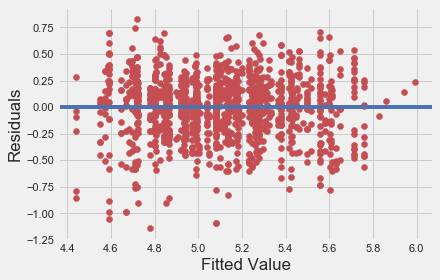

In [52]:
plt.scatter(pred_df3.logpred, pred_df3.residuals2, color = 'r')
plt.axhline(0, color = 'b')
plt.xlabel('Fitted Value')
plt.ylabel('Residuals')
plt.show()

(array([  3.,   1.,   3.,   3.,   3.,   7.,   3.,   4.,  22.,  27.,  35.,
         33.,  50.,  67.,  88.,  85., 126., 133., 133., 150.,  92.,  93.,
         56.,  39.,  31.,  13.,   7.,   6.,   5.,   1.]),
 array([-1.13989302, -1.07426758, -1.00864215, -0.94301672, -0.87739128,
        -0.81176585, -0.74614041, -0.68051498, -0.61488955, -0.54926411,
        -0.48363868, -0.41801325, -0.35238781, -0.28676238, -0.22113694,
        -0.15551151, -0.08988608, -0.02426064,  0.04136479,  0.10699022,
         0.17261566,  0.23824109,  0.30386653,  0.36949196,  0.43511739,
         0.50074283,  0.56636826,  0.63199369,  0.69761913,  0.76324456,
         0.82887   ]),
 <a list of 30 Patch objects>)

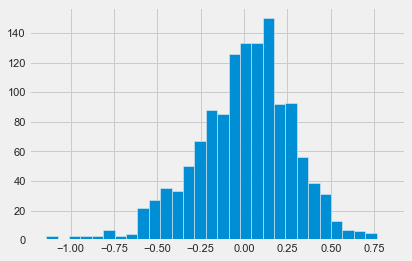

In [53]:
plt.hist(pred_df3.residuals2, bins = 30)

- Our base line model has district 10 and review score of Exceptional. It makes sense since the further away from city center (around district 5, 6, 4), the lower the price will become. Similarly, as rating going down from Exceptional, the hotel price is decreasing. 
- Again, by using categorical data of rating, our model's R2 is getting better.

/Users/Mavis/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


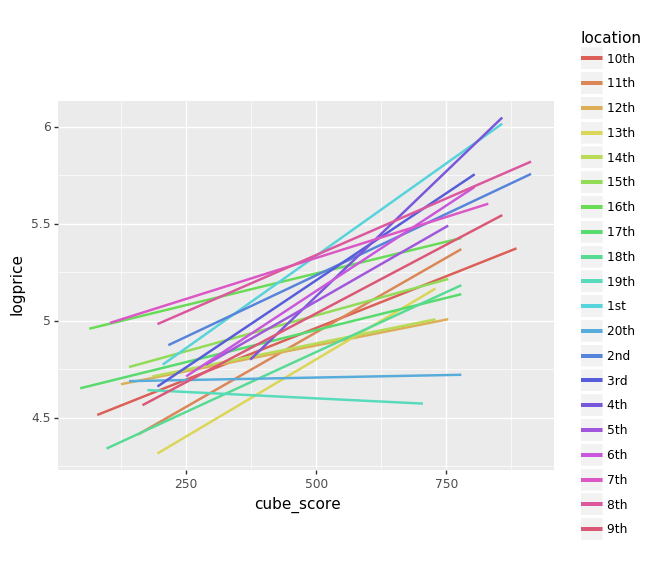

<ggplot: (7551856909)>

In [67]:
import plotnine as p9

p9.ggplot(paris, p9.aes(x = 'cube_score', y = 'logprice', colour = 'location')) \
+ p9.geom_smooth(method = "lm", se=False)